**VM: Deep Learning mit Python - Model from scratch**

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

# Imports and definitions

In [1]:
# Import of packages

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping

import calendar
import os
from google.colab import drive
from packaging import version

assert version.parse(tf.__version__) >= version.parse('2.5.0')

In [2]:
# mount Google drive to get the data

drive.mount('/content/gdrive', force_remount=False)
root_path = 'gdrive/My Drive/Wirtschaftsinformatik/lulc_data'

Mounted at /content/gdrive


In [3]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [4]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

# Data loading and exploration

**Loading data**

In [ ]:
data = data = np.load(root_path + '/train.npz')
bands = data['bands'] # data: 10.000 patches, each for twelve months and with six channels. Resolution: 33x33 pixels
lulc = data['lulc'] # labels for central pixel of patches (Land Use and Land Cover)
print(bands.shape)
print(lulc.shape)

(10000, 12, 33, 33, 6)
(10000,)


**Examine data**

In [ ]:
%%script false
# show number of instances per class

count_classes = []
for i in range(11): 
    val = np.count_nonzero(lulc == i)
    print("class "+str(i)+": "+str(val))
    count_classes.append(val)
#print(count_classes)

In [ ]:
%%script false
# print bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = list(class_names.values())
ax.bar(classes,count_classes)
plt.xticks(rotation=45)
plt.show()

--> Realization: Class 2 is over-represented. Classes 6, 7 and 10 are not present in the data set at all.

In [ ]:
%%script false
# Show some images

patch = 250 # random patch number

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

# Data Preparation

**Split data into train, validation and test data**

In [ ]:
X = bands
y = lulc

# split into train, test, vaildation sets
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)
print(X_train.shape)

(6400, 12, 33, 33, 6)


In [ ]:
# clear variables to save RAM
del data
del bands
del lulc
del X
del y

**Class weights** 

In [ ]:
# Calculate class weights automatically
class_weights_array = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Create dictionary for the class weights
class_weights_dict = {
    0: class_weights_array[0],
    1: class_weights_array[1],
    2: class_weights_array[2],
    3: class_weights_array[3],
    4: class_weights_array[4],
    5: class_weights_array[5],
    6: 0,
    7: 0,
    8: class_weights_array[6],
    9: class_weights_array[7],
    10: 0,
}

print(class_weights_dict)

{0: 0.9815950920245399, 1: 5.298013245033113, 2: 0.21511158913686476, 3: 1.0914051841746248, 4: 1.6326530612244898, 5: 19.047619047619047, 6: 0, 7: 0, 8: 6.015037593984962, 9: 2.5236593059936907, 10: 0}


**One-hot encoder**

In [ ]:
# one-hot encoder for categorical_crossentropy loss to work in model
depth = 11
y_train = tf.one_hot(y_train, depth)
y_val = tf.one_hot(y_val, depth)
y_test = tf.one_hot(y_test, depth)

**Data augmentation**

In [ ]:
#%%script false
# Create Tensorflow Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(6400, shape=(), dtype=int64)
tf.Tensor(1600, shape=(), dtype=int64)
tf.Tensor(2000, shape=(), dtype=int64)


In [ ]:
# clear variables to have more RAM
del X_train
del y_train
del X_val
del y_val

Code from: [Tensorflow - Data augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [ ]:
#%%script false
# create data augmentation layer
data_augmentation_ver = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

data_augmentation_hor = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# define prepare function from tensorflow website
def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set
  if augment:
    import random
    rand = random.uniform(0, 1)
    if rand == 0:
      ds = ds.map(lambda x, y: (data_augmentation_hor(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    else:
      ds = ds.map(lambda x, y: (data_augmentation_ver(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds, shuffle=True)
test_ds = prepare(test_ds, shuffle=True)

print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(200, shape=(), dtype=int64)
tf.Tensor(50, shape=(), dtype=int64)
tf.Tensor(63, shape=(), dtype=int64)


# Model choosing

**Build 3D CNN Model from scratch**

adapted by: https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

In [ ]:
base_model = Sequential() # sequential model
base_model.add(Conv3D(32, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(12, 33, 33, 6)))
base_model.add(Conv3D(32, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='he_uniform'))
base_model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
base_model.add(MaxPooling3D(pool_size=(4, 4, 4)))
base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.4))
base_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
base_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
#base_model.add(MaxPooling3D(pool_size=(3, 3, 3)))
base_model.add(BatchNormalization(center=True, scale=True))
base_model.add(Dropout(0.4))
base_model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
base_model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
base_model.add(MaxPooling3D(pool_size=(3, 3, 3)))
base_model.add(BatchNormalization(center=True, scale=True))
#base_model.add(GlobalAveragePooling3D((4, 4, 4))
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dropout(0.4))
base_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dropout(0.4))
base_model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
base_model.add(Dropout(0.4))
base_model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

In [ ]:
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 33, 33, 32)    5216      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 31, 31, 32)    27680     
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 31, 31, 32)    128       
_________________________________________________________________
dropout (Dropout)            (None, 10, 31, 31, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 31, 31, 64)    55360     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 29, 29, 64)     110656    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 4, 14, 14, 64)     0

# Model training

**Define callbacks**

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learningrate_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 15)
checkpoint_cb = keras.callbacks.ModelCheckpoint("own_model.h5", save_best_only=True)

**Fitting Model**

In [ ]:
#%%script false
# history = base_model.fit(X_train, y_train, epochs=100, batch_size=32, 
#                     validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb],
#                     class_weight=class_weights_dict)

history = base_model.fit(train_ds, epochs=100, batch_size=32, 
                    validation_data=val_ds, callbacks=[checkpoint_cb, early_stopping_cb, learningrate_cb],
                    class_weight=class_weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
200/200 [==============================] - 148s 500ms/step - loss: 3.2007 - accuracy: 0.1827 - val_loss: 2.5400 - val_accuracy: 0.1138
Epoch 2/100
200/200 [==============================] - 100s 498ms/step - loss: 2.1023 - accuracy: 0.1809 - val_loss: 1.7936 - val_accuracy: 0.2362
Epoch 3/100
200/200 [==============================] - 100s 498ms/step - loss: 1.7474 - accuracy: 0.2310 - val_loss: 1.6424 - val_accuracy: 0.3525
Epoch 4/100
200/200 [==============================] - 100s 498ms/step - loss: 1.6439 - accuracy: 0.2801 - val_loss: 1.4606 - val_accuracy: 0.4137
Epoch 5/100
200/200 [==============================] - 100s 498ms/step - loss: 1.4777 - accuracy: 0.3459 - val_loss: 1.6260 - val_accuracy: 0.3363
Epoch 6/100
200/200 [==============================] - 100s 498ms/step - loss: 1.4146 - accuracy: 0.3534 - val_loss: 1.5893 - v

In [5]:
#%%script false
#base_model.save('gdrive/My Drive/Wirtschaftsinformatik/lulc_data/own_trainingData_210714.h5') # save model in root directory
#Error: model = keras.models.load_model('own_model.h5')
base_model = keras.models.load_model('gdrive/My Drive/Wirtschaftsinformatik/lulc_data/own_trainingData_210714.h5')

# Evaluation

In [ ]:
#%%script false
# Calculate loss and accuracy
base_model.evaluate(X_test, y_test)

NameError: ignored

In [ ]:
#%%script false
#Plot accuracy and loss of train and val set
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

NameError: ignored

# Make Predictions

**Testing on Public Test Set**

In [8]:
data_public_test = np.load(root_path + '/public_test.npz') # load public test set
bands_public_test = data_public_test['bands'] # extract only layer called 'bands'
print(bands_public_test.shape)

(12, 500, 500, 6)


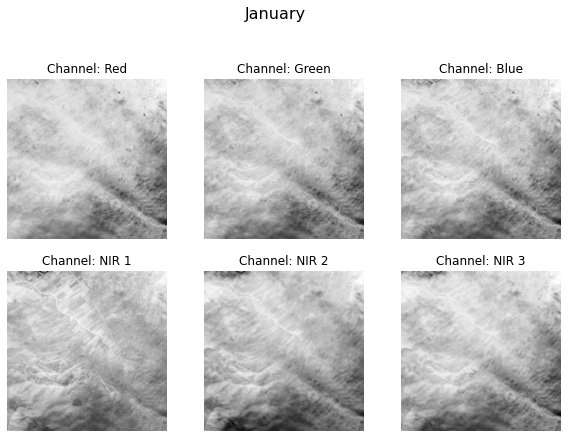

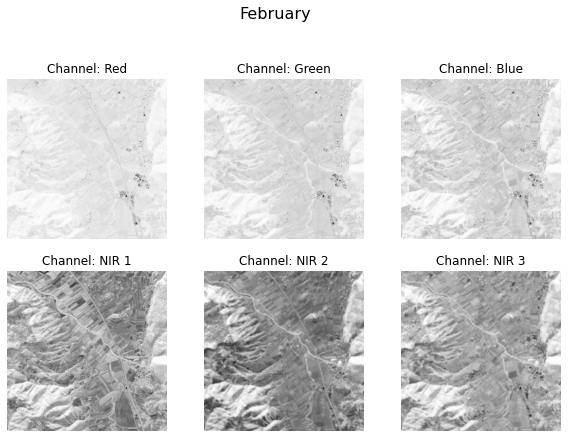

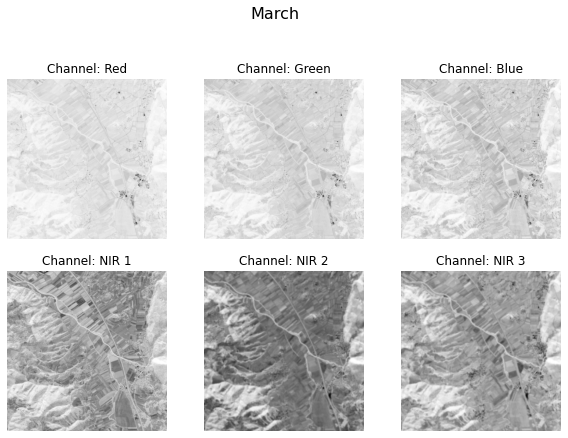

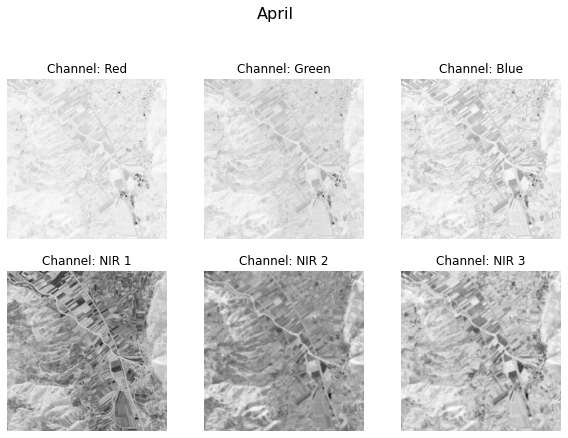

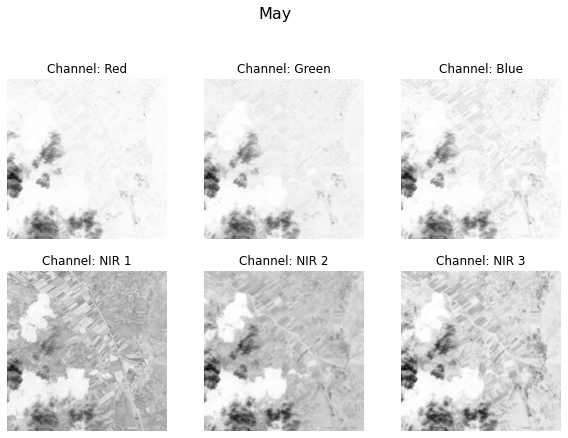

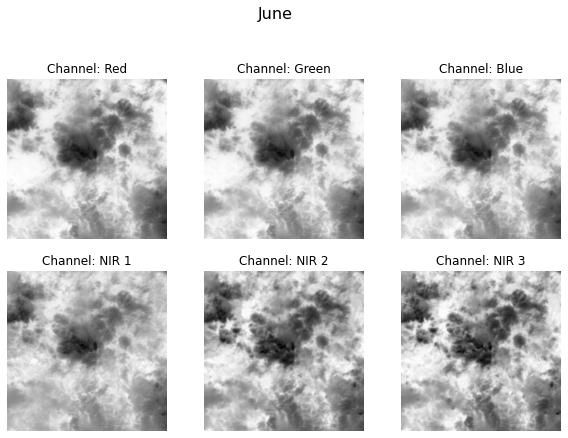

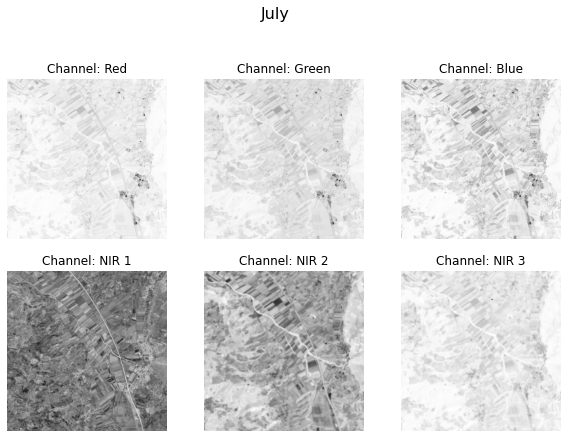

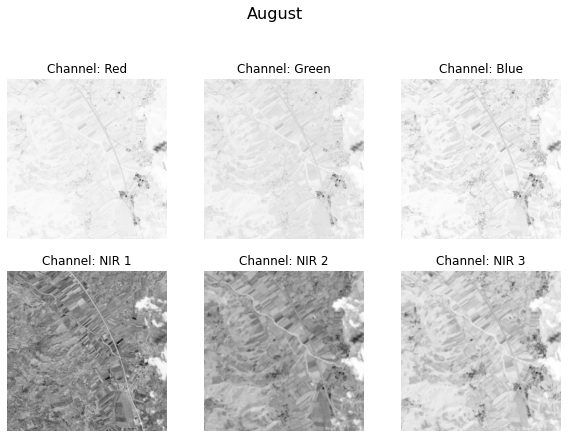

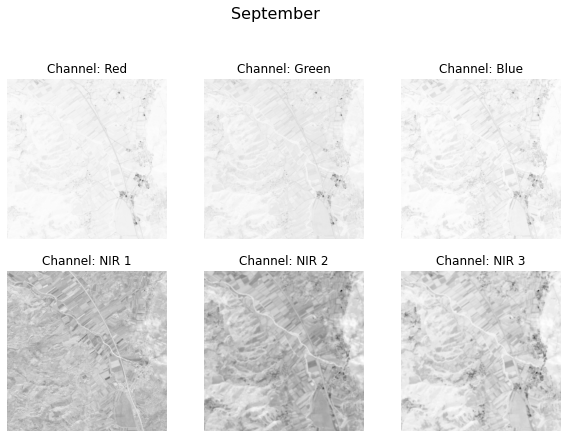

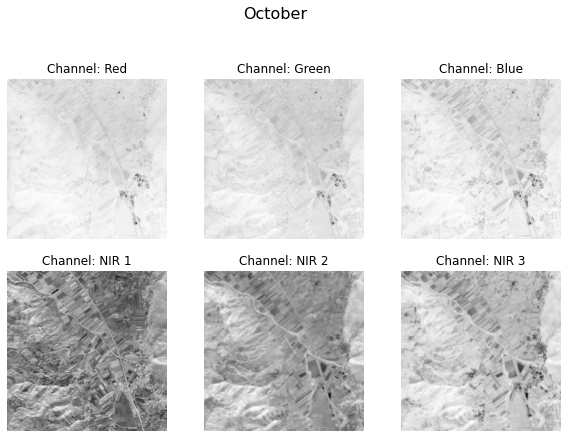

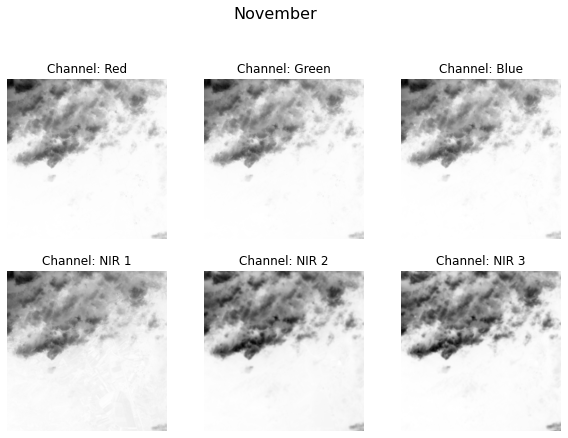

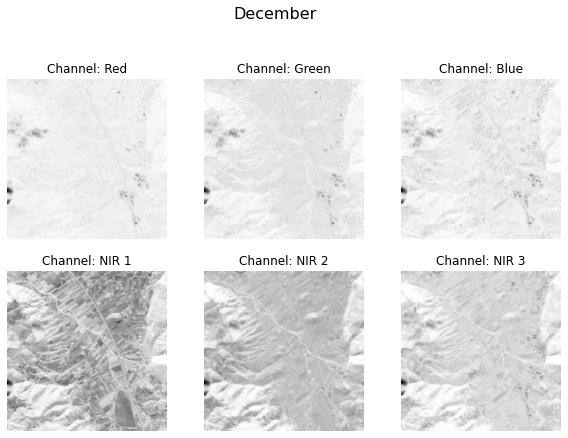

In [9]:
# Show all 12 monthly images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test[month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Padding**

To be able to use the sliding window approach on the public test set.

In [10]:
bands_public_test_pad = np.zeros(shape=(12, 532, 532, 6)) # get empty array with correct shape

# perform padding for all images (months and channels)
for month in range(12):
    for channel in range(6):
        bands_public_test_pad[month, :, :,channel] = np.pad(bands_public_test[month, :, :,channel],
                                                            ((16,16),(16,16)), 'constant')
        
print(bands_public_test_pad.shape)

(12, 532, 532, 6)


Test padding by printing out the images of the public test set.

TypeError: ignored

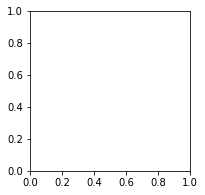

In [20]:
for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test_pad[month, :, :, channel]
        plt.imshow(image)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off") 

In [13]:
#1: NP array
# add one dimension to be able feeding our model

#bands_public_test = np.expand_dims(bands_public_test, 0)
bands_public_test_pad = np.expand_dims(bands_public_test_pad, 0)
bands_public_test_pad.shape

#2: list
y_pred_public_test = [[0]*468]*468 # 2D Liste 

#len(y_pred_public_test[5])
y_pred_public_test[2][444]

0

**Naive sliding window approach**

Iterate the model over the whole public test image with stepsize one.

In [17]:
# Ausschnittskoordinaten für die Prediction definieren
x_coord_start = 15
x_coord_end = x_coord_start + 33

#Zeile zuerst predicted, danach Spalte
for cur_row in range(468):
    # Ausschnittskoordinaten für die nächste Prediction erhöht
    x_coord_end   += 1
    x_coord_start += 1
    y_coord_start = 15
    y_coord_end = y_coord_start + 33
    
    y_pred_public_test_row = []
    for cur_col in range(468):
        y_coord_end   += 1
        y_coord_start += 1
        # pass every month & color channel 
        current_cutout = bands_public_test_pad[:, :, x_coord_start:x_coord_end, y_coord_start:y_coord_end, :]
        #maybe month:month+1 with extra month loop (problematic, because you overwrite previous prediction

        y_pred = base_model.predict_classes(current_cutout)
        #y_pred_public_test[cur_col][cur_row] = y_pred[0] # Nr. 2 Alles direkt in Liste predicten 
        y_pred_public_test_row.append(y_pred[0]) # Nr. 1 Spalte predicted

    y_pred_public_test[cur_col] = y_pred_public_test_row # Nr. 1 Spalte in Liste hinzugefügt
    print(y_pred_public_test[cur_col]) # Nr. 1 Spaltenprediction printen

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ValueError: ignored

In [ ]:
y_pred_public_test = numpy.array(y_pred_public_test) #convert list to numpy array

In [ ]:
#%%script false
with open("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_public_test.npy", "wb") as f:
    np.save(f, y_pred_public_test)

In [ ]:
#%%script false
with open("gdrive/My Drive/Wirtschaftsinformatik/lulc_data/y_pred_public_test.npy", "rb") as f:
    y_pred_public_test = np.load(f)

**Visualization of the result for the public test set**

Code adapted from https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color

In [ ]:
color_map = {
    0:  np.array([  0,   0,   0]), #0: "No Data"
    1:  np.array([240, 222,  60]), #1: "Cultivated Land"
    2:  np.array([ 47, 102,  31]), #2: "Forest"
    3:  np.array([162, 232, 142]), #3: "Grassland"
    4:  np.array([162, 176, 158]), #4: "Shrubland"
    5:  np.array([ 99, 189, 224]), #5: "Water"
    6:  np.array([ 44, 209, 154]), #6: "Wetlands"
    7:  np.array([230, 189,  41]), #7: "Tundra"
    8:  np.array([237,  82,  55]), #8: "Artificial Surface"
    9:  np.array([224, 180, 132]), #9: "Bareland"
    10: np.array([189, 189, 189]), #10: "Snow and Ice"
} 

# make a 3d numpy array that has a color channel dimension   
data_3d = np.ndarray(shape=(y_pred_public_test.shape[0], y_pred_public_test.shape[1],3), dtype=int)
for i in range(0, y_pred_public_test.shape[0]):
    for j in range(0, y_pred_public_test.shape[1]):
        data_3d[i][j] = color_map[y_pred_public_test[j,i,0]]
        print(data_3d[i][j])

# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)

In [ ]:
# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)